# Исследование среднего веса новорожденных

В данной работе я исследовала кейс из одного известного Telegram-канала и выполнила предложенные автором упражнения.

В нашем распоряжении данные Национального исследования роста семьи (NSFG). Данное исследование, проведено отделом Статистики здравоохранения Центра по контролю и профилактике заболеваний, чтобы понять тенденции, связанные с фертильностью, структурой семьи и демографией в Соединенных Штатах.

Наша задача - проанализировать имеющиеся данные и выяснить, каков средний вес новорожденных в Соединенных Штатах.

Респонденты NSFG предоставили общую информацию о себе, которая хранится в файле респондентов, и информацию о каждой беременности, которая хранится в файле о беременности.

Мы будем работать с файлом беременности, который содержит по одной строке для каждой беременности и 248 переменных. Каждая переменная представляет собой ответы на вопрос анкеты NSFG.

В дополнение к файлу данных (2015_2017_FemPregData.dat) нам также понадобится словарь данных (2015_2017_FemPregSetup.dct), который включает имена переменных и указывает диапазон столбцов, в которых появляется каждая переменная.

In [1]:
dict_file = '2015_2017_FemPregSetup.dct'
data_file = '2015_2017_FemPregData.dat'

In [2]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

In [3]:
download('https://ftp.cdc.gov/pub/health_statistics/nchs/' +
         'datasets/NSFG/stata/' + dict_file)

In [4]:
download('https://ftp.cdc.gov/pub/health_statistics/nchs/' +
         'datasets/NSFG/' + data_file)


Pandas может читать данные в наиболее распространенных форматах, включая CSV, Excel и формате фиксированной ширины, но не может читать словарь данных, который находится в формате Stata.
Для этого мы будем использовать библиотеку Python под названием parse_stata_dict.
Следующая ячейка при необходимости устанавливает parse_stata_dict.

In [5]:
try:
    from statadict import parse_stata_dict
except ImportError:
    !pip install statadict

Из parse_stata_dict мы импортируем функцию parse_stata_dict, которая читает словарь данных.

In [6]:
from statadict import parse_stata_dict

stata_dict = parse_stata_dict(dict_file)
stata_dict

В результате получается объект, содержащий атрибуты

names, который представляет собой список имен переменных, и

colspecs, который представляет собой список кортежей.

Каждый кортеж в colspecs определяет первый и последний столбцы, в которых появляется переменная.

Эти значения - именно те аргументы, которые нам нужны для использования read_fwf, функции Pandas, считывающей файл в формате фиксированной ширины.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

nsfg = pd.read_fwf(data_file,
                   names=stata_dict.names,
                   colspecs=stata_dict.colspecs)
type(nsfg)

pandas.core.frame.DataFrame

In [8]:
nsfg.head()

,CASEID,PREGORDR,HOWPREG_N,HOWPREG_P,MOSCURRP,NOWPRGDK,PREGEND1,PREGEND2,HOWENDDK,NBRNALIV,...,SECU,SEST,CMINTVW,CMLSTYR,CMJAN3YR,CMJAN4YR,CMJAN5YR,QUARTER,PHASE,INTVWYEAR
0,70627,1,NaN,NaN,NaN,NaN,6.0,NaN,NaN,1.0,...,3,322,1394,1382,1357,1345,1333,18,1,2016
1,70627,2,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,3,322,1394,1382,1357,1345,1333,18,1,2016
2,70627,3,NaN,NaN,NaN,NaN,6.0,NaN,NaN,1.0,...,3,322,1394,1382,1357,1345,1333,18,1,2016
3,70628,1,NaN,NaN,NaN,NaN,6.0,NaN,NaN,1.0,...,2,366,1409,1397,1369,1357,1345,23,1,2017
4,70628,2,NaN,NaN,NaN,NaN,6.0,NaN,NaN,1.0,...,2,366,1409,1397,1369,1357,1345,23,1,2017


Первый столбец - это CASEID, который представляет собой уникальный идентификатор для каждого респондента.
Первые три строки содержат один и тот же CASEID, поэтому респондентка сообщила информацию о трех беременностях.
Второй столбец - это PREGORDR, который указывает порядок беременностей для каждой респондентки, начиная с 1.

In [9]:
nsfg.shape

(9553, 248)

В этом наборе данных 9553 строки, по одной для каждой беременности, и 248 столбцов, по одной для каждой переменной.

In [58]:
nsfg.columns

Index(['CASEID', 'PREGORDR', 'HOWPREG_N', 'HOWPREG_P', 'MOSCURRP', 'NOWPRGDK',
       'PREGEND1', 'PREGEND2', 'HOWENDDK', 'NBRNALIV',
       ...
       'SECU', 'SEST', 'CMINTVW', 'CMLSTYR', 'CMJAN3YR', 'CMJAN4YR',
       'CMJAN5YR', 'QUARTER', 'PHASE', 'INTVWYEAR'],
      dtype='object', length=248)

Имена столбцов хранятся в Index, который является типом Pandas, похожим на список.

Основываясь на именах столбцов, можно догадаться, что это за переменные, но в целом нам необходимо прочитать документацию.

Кодовая книга NSFG описывает каждую переменную. К сожалению, она больше не доступна, поэтому необходимо использовать PDF-файл, который содержит краткое описание каждой переменной.

Если мы выполним поиск в этом документе по запросу "weigh at birth", мы найдём следующие переменные, связанные с массой тела при рождении.

BIRTHWGT_LB1: масса тела при рождении в фунтах (Pounds) - первый ребенок от этой беременности.

BIRTHWGT_OZ1: вес при рождении в унциях (Ounces) - первый ребенок от этой беременности.

Подобные переменные существуют также для 2-го или 3-го ребенка в случае двойни или тройни. Но сейчас мы сосредоточимся на первом ребенке от каждой беременности и вернемся к вопросу о многоплодных родах позже.

In [11]:
#Создам список с весом новорождённых в фунтах:
pounds = nsfg['BIRTHWGT_LB1']
pounds.head()

0    7.0
1    NaN
2    9.0
3    6.0
4    7.0
Name: BIRTHWGT_LB1, dtype: float64

***Упражнение***: Переменная BIRTHWGT_OZ1 содержит часть веса при рождении в унциях.

Выберите столбец 'BIRTHWGT_OZ1' из фрейма данных nsfg и присвойте его новой переменной с именем ounces. Затем отобразите первые пять элементов ounces.

In [60]:
ounces = nsfg['BIRTHWGT_OZ1']
ounces.head()

0    8.0
1    NaN
2    2.0
3    9.0
4    0.0
Name: BIRTHWGT_OZ1, dtype: float64

Использую метод value_counts, чтобы увидеть, какие значения имеются в pounds и сколько раз повторяется каждое значение.

In [13]:
pounds.value_counts()

7.0     2268
6.0     1644
8.0     1287
5.0      570
9.0      396
4.0      179
99.0      89
10.0      82
3.0       76
2.0       46
1.0       28
11.0      17
0.0        2
12.0       2
98.0       2
14.0       1
13.0       1
Name: BIRTHWGT_LB1, dtype: int64

In [14]:
pounds.value_counts().sort_index()

0.0        2
1.0       28
2.0       46
3.0       76
4.0      179
5.0      570
6.0     1644
7.0     2268
8.0     1287
9.0      396
10.0      82
11.0      17
12.0       2
13.0       1
14.0       1
98.0       2
99.0      89
Name: BIRTHWGT_LB1, dtype: int64

Наиболее частыми являются значения 6-8 фунтов, но есть несколько очень легких детей, несколько очень тяжелых детей и два специальных значения, 98 и 99. Согласно кодовой книге, эти значения указывают на то, что респондент отказался отвечать на вопрос (98) или не знал (99).

Посмотрю описание данных столбца pounds с помощью метода describe, который показывает сводную статистику, такую как среднее значение, стандартное отклонение, минимум и максимум.

In [15]:
pounds.describe()

count    6690.000000
mean        8.008819
std        10.771360
min         0.000000
25%         6.000000
50%         7.000000
75%         8.000000
max        99.000000
Name: BIRTHWGT_LB1, dtype: float64

Среднее значение составляет примерно 8.01, но этот показатель мало что значит, потому что он включает специальные значения 98 и 99. Прежде чем мы сможем вычислить реальное среднее значение, нам нужно заменить эти значения на NaN, чтобы идентифицировать их как отсутствующие данные.

In [16]:
#Методом replace() заменим значения 98 и 99 на NaN:
pounds_clean = pounds.replace([98, 99], np.nan)

In [17]:
pounds_clean.describe()

count    6599.000000
mean        6.754357
std         1.383268
min         0.000000
25%         6.000000
50%         7.000000
75%         8.000000
max        14.000000
Name: BIRTHWGT_LB1, dtype: float64

После замены выбросов на NaN средний вес составил примерно 6.75 фунтов. 

***Упражнение***: Используйте describe, чтобы суммировать ounces.
Затем используйте replace, чтобы заменить специальные значения 98 и 99 на NaN, и присвойте результат переменной ounces_clean.
Снова запустите describe. Насколько эта очистка влияет на результат?

In [18]:
ounces.describe()

count    6601.000000
mean        7.642327
std         9.907332
min         0.000000
25%         3.000000
50%         7.000000
75%        11.000000
max        99.000000
Name: BIRTHWGT_OZ1, dtype: float64

Средний вес в унциях равен приблизительно 7.64, заменю значения 98 и 99 на NaN и посмотрю, как изменится этот показатель.

In [19]:
ounces_clean = ounces.replace([98, 99], np.nan)

In [20]:
ounces_clean.describe()

count    6540.000000
mean        6.790520
std         4.532309
min         0.000000
25%         3.000000
50%         7.000000
75%        11.000000
max        15.000000
Name: BIRTHWGT_OZ1, dtype: float64

Теперь средний вес уменьшился и стал равен 6.79 унций.

***Упражнение***: Используйте pounds_clean и ounces_clean, чтобы вычислить общий вес при рождении, выраженный в килограммах (это примерно 2,2 фунта на килограмм). Какой средний вес при рождении в килограммах?

Преобразую унции в pounds, разделив на 16 и посчитаю общий вес новорождённых.

In [21]:
all_weight_pounds = pounds_clean + ounces_clean / 16
print(all_weight_pounds)

0       7.5000
1          NaN
2       9.1250
3       6.5625
4       7.0000
         ...  
9548    7.1250
9549       NaN
9550    8.7500
9551    6.8125
9552       NaN
Length: 9553, dtype: float64


Разделю вес в pounds на 2.2 и получу вес в килограммах.

In [22]:
weight_kilos = all_weight_pounds / 2.2
print(weight_kilos)

0       3.409091
1            NaN
2       4.147727
3       2.982955
4       3.181818
          ...   
9548    3.238636
9549         NaN
9550    3.977273
9551    3.096591
9552         NaN
Length: 9553, dtype: float64


In [23]:
weight_kilos.describe()

count    6540.000000
mean        3.263735
std         0.625982
min         0.227273
25%         2.926136
50%         3.295455
75%         3.636364
max         6.448864
dtype: float64

Средний вес новорождённых в килограммах равен приблизительно 3.26.

***Упражнение***: Для каждой беременности в наборе данных NSFG переменная 'AGECON' кодирует возраст респондента на момент зачатия, а 'AGEPREG' - возраст респондента в конце беременности.
Обе переменные записываются как целые числа с двумя неявными десятичными знаками, поэтому значение 2575 означает, что возраст респондента был 25.75.
Выберите 'AGECON' и 'AGEPREG', разделите их на 100 и присвойте их переменным с именами agecon и agepreg.
Вычислите разницу, которая является оценкой продолжительности беременности.
Используйте .describe() для вычисления средней продолжительности и другой сводной статистики.

In [24]:
agecon = nsfg['AGECON'] / 100
print(agecon)

0       0.28
1       0.32
2       0.33
3       0.17
4       0.19
        ... 
9548    0.20
9549    0.23
9550    0.31
9551    0.33
9552    0.32
Name: AGECON, Length: 9553, dtype: float64


In [25]:
agepreg = nsfg['AGEPREG'] / 100
print(agepreg)

0       0.29
1       0.32
2       0.33
3       0.18
4       0.20
        ... 
9548    0.20
9549    0.23
9550    0.32
9551    0.34
9552     NaN
Name: AGEPREG, Length: 9553, dtype: float64


In [26]:
pregnancy_duration = agepreg - agecon

In [27]:
pregnancy_duration.describe()

count    9352.000000
mean        0.005549
std         0.004970
min         0.000000
25%         0.000000
50%         0.010000
75%         0.010000
max         0.010000
dtype: float64

Средняя продолжительность беременности равна примерно 0.006 лет, но сюда также относятся беременности, которые не закончились рождением.

### Каков средний вес новорожденных в США?

Перед тем как ответить на вопрос, каков средний вес новорожденных в США, посмотрю на распределение весов с помощью гистограммы.

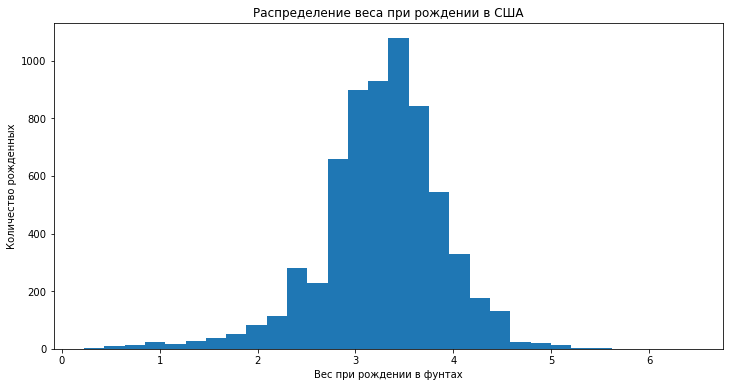

In [67]:
plt.figure(figsize = (12, 6))
weight_kilos.hist(bins = 30, grid = False)
plt.xlabel('Вес при рождении в фунтах')
plt.ylabel('Количество рожденных')
plt.title('Распределение веса при рождении в США')
plt.show()

Распределение близко к нормальному, но хвост слева длиннее, чем справа, это означает, что младенцев с маленьким весом больше, чем тяжелых.

***Упражнение***: Как мы видели в предыдущем упражнении, набор данных NSFG включает столбец под названием AGECON, в котором записывается возраст на момент зачатия для каждой беременности.
Выберите этот столбец в DataFrame и разделите на 100, чтобы преобразовать его в годы.
Постройте гистограмму этих значений с 20 ячейками (bins).
Обозначьте оси x и y соответствующим образом.

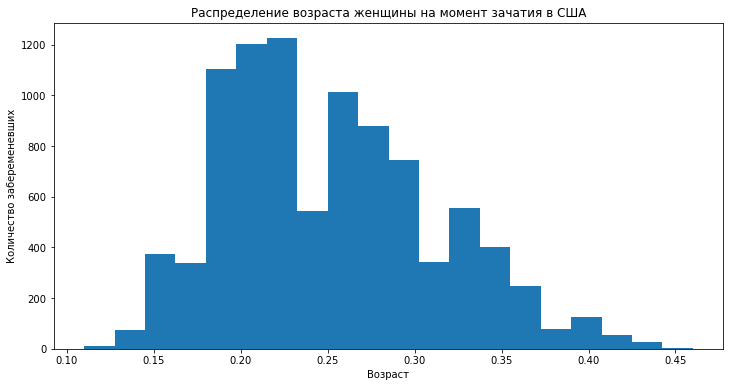

In [68]:
plt.figure(figsize = (12, 6))
agepreg.hist(bins = 20, grid = False)
plt.xlabel('Возраст')
plt.ylabel('Количество забеременевших')
plt.title('Распределение возраста женщины на момент зачатия в США')
plt.show()

Возраст, в котором чаще всего происходит зачатие равен 18-23 года.

Посмотрю на распределение продолжительности беременности. Использую столбец 'PRGLNGTH', который содержит продолжительность беременности в неделях.

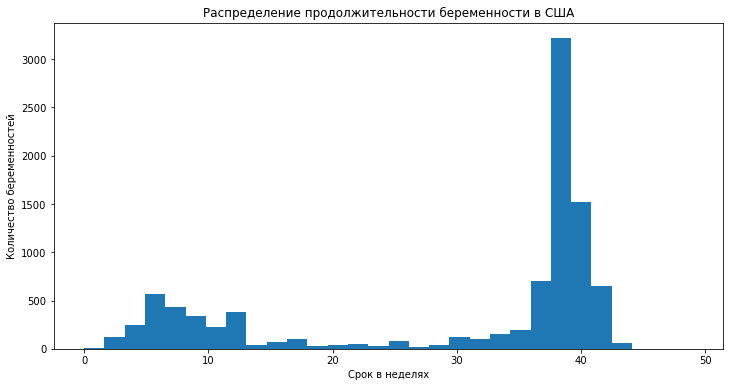

In [72]:
plt.figure(figsize = (12, 6))
nsfg['PRGLNGTH'].hist(bins = 30, grid = False)
plt.xlabel('Срок в неделях')
plt.ylabel('Количество беременностей')
plt.title('Распределение продолжительности беременности в США')
plt.show()

Наиболее частая продолжительность беременности составляет 39 недель, что является "доношенной", "недоношенность" обычно определяется сроком менее 37 недель.

Узнаю, какие дети недоношены, применю фильтр PRGLNGTH < 37.

In [30]:
preterm = (nsfg['PRGLNGTH'] < 37)
preterm.dtype

dtype('bool')

In [31]:
preterm.head()

0    False
1     True
2    False
3    False
4    False
Name: PRGLNGTH, dtype: bool

In [32]:
preterm.sum()

3675

Количество недоношенных детей равно 3675.

In [33]:
preterm.mean()

0.38469590704490736

Примерно 38% беременностей длится менее 37 недель.

Но выше полученный результат может вводить в заблуждение, так как он включает все исходы беременности - не только рождения. Создам еще одну логическую серию, чтобы указать, какие беременности закончились рождением:

In [73]:
live = (nsfg['OUTCOME'] == 1)
live.mean()

0.7006176070344394

Найдём, какой процент беременностей закончился преждевременными родами:

In [35]:
live_preterm = (live & preterm)
live_preterm.mean()

0.08929132209777034

***Упражнение***: Какая доля всех беременностей является доношенной, то есть 37 недель или более? Какая доля всех рожденных является доношенными?

In [36]:
term_pregnancy = (nsfg['PRGLNGTH'] >= 37)
term_pregnancy.head()

0     True
1    False
2     True
3     True
4     True
Name: PRGLNGTH, dtype: bool

In [37]:
term_pregnancy.sum()

5878

In [38]:
term_pregnancy.mean()

0.6153040929550927

61.5% беременностей являются доношенными.

In [39]:
live_term = (live & term_pregnancy)
live_term.mean()

0.6113262849366691

61.1% детей являются доношенными.

In [40]:
preterm_weight = weight_kilos[preterm]
preterm_weight.mean()

2.4913449006190937

Средний вес при рождении для недоношенных детей равен примерно 2.49 колограмм.

Чтобы выбрать доношенных детей, создадим логическую серию следующим образом:

In [41]:
fullterm = (nsfg['PRGLNGTH'] >= 37)

In [42]:
full_term_weight = weight_kilos[fullterm]
full_term_weight.mean()

3.377095189134898

Доношенные дети тяжелее недоношенных, их средний вес равен приблизительно 3.38 . 

***Упражнение***: Посмотрим, есть ли разница в весе между одноплодными и многоплодными родами (двойняшки, тройни и т. д.).
Переменная NBRNALIV представляет количество детей, рожденных живыми от одной беременности.

In [44]:
nbrnaliv = nsfg['NBRNALIV']
nbrnaliv.value_counts()

1.0    6573
2.0     111
3.0       6
Name: NBRNALIV, dtype: int64

Создам список с множественными рождениями:

In [45]:
multiple = (nsfg['NBRNALIV'] > 1)
print(multiple)

0       False
1       False
2       False
3       False
4       False
        ...  
9548    False
9549    False
9550    False
9551    False
9552    False
Name: NBRNALIV, Length: 9553, dtype: bool


Какая доля всех рождений приходится на многоплодие?

In [46]:
multiple.mean()

0.012247461530409296

На многоплодие приходится 0.01% беременностей.

Создам список с единичными рождениями:

In [47]:
single = (nsfg['NBRNALIV'] == 1)
print(single)

0        True
1       False
2        True
3        True
4        True
        ...  
9548     True
9549    False
9550     True
9551     True
9552    False
Name: NBRNALIV, Length: 9553, dtype: bool


In [48]:
single_preterm = (single & preterm)
single_preterm.mean()

0.08301057259499633

Около 8% всех одноплодных родов является преждевременными.

In [49]:
preterm_part = ((multiple | single) & preterm)
preterm_part.mean()

0.08929132209777034

Около 9% всех родов является преждевременными.

***Упражнение***: Каков средний вес при рождении живыми (live), одноплодными (single) и доношенными (full-term births)?

In [50]:
single_live_fullterm_weight = weight_kilos[live & single & fullterm]
single_live_fullterm_weight.mean()

3.3836193020860073

3.38 килограмм в среднем весит живой, доношенный ребёнок рождённый при одноплодных родах.

### Средневзвешенное значение

NSFG не совсем репрезентативен для населения США. По замыслу, некоторые группы чаще появляются в выборке, чем другие; то есть они передискретизированы (oversampled). Передискретизация помогает гарантировать, что у вас будет достаточно людей в каждой подгруппе для получения надежной статистики, но это немного усложняет анализ данных.
Каждая беременность в наборе данных имеет вес выборки (sampling weight), который указывает, сколько беременностей она представляет. В nsfg вес выборки хранится в столбце с именем wgt2015_2017. Вот как это выглядит.

In [51]:
sampling_weight = nsfg['WGT2015_2017']
sampling_weight.describe()

count      9553.000000
mean      13337.425944
std       16138.878271
min        1924.916000
25%        4575.221221
50%        7292.490835
75%       15724.902673
max      106774.400000
Name: WGT2015_2017, dtype: float64

Среднее значение (50-й процентиль) в этом столбце составляет около 7292, это означает, что беременность с таким весом представляет собой 7292 беременностей в популяции.
Чтобы учесть эти веса, нам нужно вычислить среднее арифметическое взвешенное (weighted mean).

In [53]:
missing = weight_kilos.isna()
missing.sum()

3013

3013 пропущенных значений в данных с весами детей.

In [54]:
valid = weight_kilos.notna()
valid.sum()

6540

Список valid содержит существующие значения с весом детей.

In [55]:
single = (nbrnaliv == 1)
selected = valid & live & single & fullterm
selected.sum()

5648

В списке selected сохраним условия valid, live, single, fullterm.

***Упражнение***: Используйте selected, birth_weight и sampling_weight, чтобы вычислить средневзвешенное значение веса при рождении для живых (live), одноплодных (single) и доношенных детей (full term).

In [75]:
weight_sum = (weight_kilos[selected] * sampling_weight[selected]).sum()
sampling_weight_sum = (sampling_weight[selected]).sum()
weighted_mean = weight_sum / sampling_weight_sum
print(weighted_mean)

3.4170191465322945


Средневзвешенное значение для веса новорождённого равно приблизительно 3.42 килограмма.

### Выводы:

В ходе исследования мы определили какой вес младенцев можно подразумевать под средним, и каких младенцев мы должны включать в рассчёты. Главными критериями при рассчёте были: одноплодная беременность, доношенность, наличие жизни.
По замыслу респонденты NSFG не являются репрезентативными для населения США, поэтому мы использовали веса выборки, чтобы скорректировать этот эффект.
Мы обнаружили, что взвешенный средний вес младенцев (3.42 кг) немного больше невзвешенного среднего (3.38 кг). Это связано с тем, что группы, для которых в NSFG представлена избыточная выборка (oversampled), как правило, в среднем рожают более легких детей.